# Build a model to decode sequences of digits from images

In [1]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import sys
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load data

In [2]:
np.random.seed(133)

def load_data(file_name,valid_size=0):
     with open(file_name, 'r') as f:
        data=pickle.load(f)
        labels=data["label"]
        images=data["image"]
        if valid_size:
            all_data=zip(images,labels)
            np.random.shuffle(all_data)
            valid_data=all_data[:valid_size]
            valid_images,valid_labels=tuple([list(l) for l in zip(*valid_data)])
            train_data=all_data[valid_size:]
            train_images,train_labels=tuple([list(l) for l in zip(*train_data)])
            return train_images,train_labels,valid_images,valid_labels
        return images,labels
valid_size=1670 #about 5% of the data
loaded_train_data,loaded_train_labels,loaded_valid_data,loaded_valid_labels=load_data("train.pickle",valid_size)
loaded_test_data,loaded_test_labels=load_data("test.pickle")
print("train:",len(loaded_train_data),len(loaded_train_labels))
print("validation:",len(loaded_valid_data),len(loaded_valid_labels))
print("test:",len(loaded_test_data),len(loaded_test_labels))

train: 31732 31732
validation: 1670 1670
test: 13068 13068


### Preprocess data

In [42]:
max_labels=3
num_labels=11
distinct_labels=np.arange(num_labels).astype(np.float32) 
blanc_label=distinct_labels[0] # 0 represensts blanc label
image_size=32

def to_one_hot(label,distincts=None):
    """convert labels to 1-hot encoding"""
    if distincts is None:
        distincts=distinct_labels
    return (distincts == label).astype(np.float32)


def from_one_hot(label):
    """retrieve labels from 1-hot encoded"""    
    return np.argmax(label)+(0 if len(label)==num_labels else 1)

def preprocess_labels(labels):
    """padd labels, and then convert them to 1-hot"""
    processed=[list() for i in range(max_labels)]
    for image_label in labels :
        for i in range(max_labels):
            distincts=distinct_labels[1:] if i==0 else distinct_labels # first label cannot be blanc, so there are only 10 candidates for the first label
            label=image_label[i] if i<len(image_label) else blanc_label 
            processed[i].append(to_one_hot(label,distincts))    
    return [np.asanyarray(l,dtype=np.float32) for l in processed]        
        

def rgb2gray(rgb):
    """convert rgb image to gray
        see http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python"""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def preprocess_images(images):
    """convert to numpy array and apply grayscale"""
    np_images=np.asanyarray(images,dtype=np.float32)
    gray_images=rgb2gray(np_images)
    reshaped_images=gray_images.reshape((-1, image_size * image_size)).astype(np.float32)
    return reshaped_images
    
def preprocess_data(images,labels):
    return preprocess_images(images),preprocess_labels(labels)
 

In [43]:
train_data,train_labels=preprocess_data(loaded_train_data,loaded_train_labels)
valid_data,valid_labels=preprocess_data(loaded_valid_data,loaded_valid_labels)
test_data,test_labels=preprocess_data(loaded_test_data,loaded_test_labels)

#### Display some labels and images to make sure that preprocessing ran fine

showing some labels and images for train
data shape:  (31732, 1024)
labels shape:  [(31732, 10), (31732, 11), (31732, 11)]
[5, 1, 1]


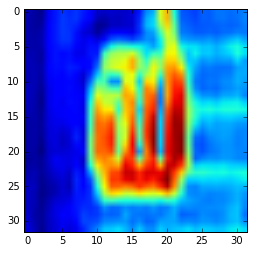

[5.0, 1.0, 1.0]


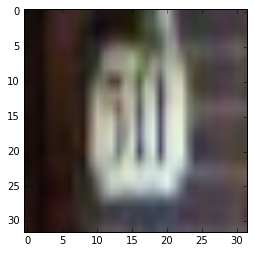

[8, 0, 0]


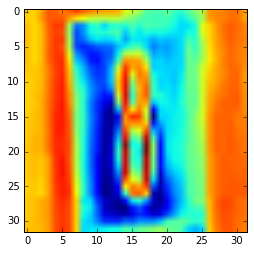

[8.0]


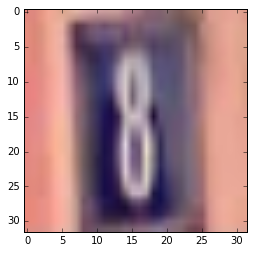

[2, 1, 0]


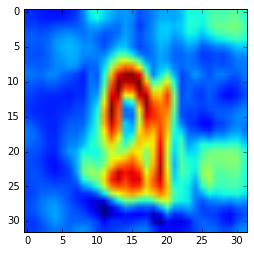

[2.0, 1.0]


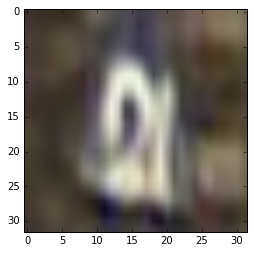

[2, 10, 9]


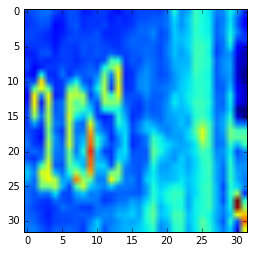

[2.0, 10.0, 9.0]


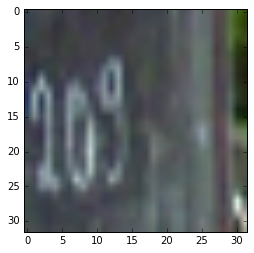

[6, 6, 4]


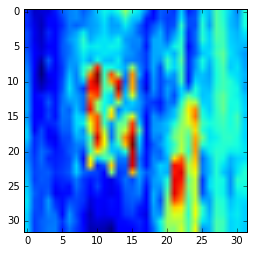

[6.0, 6.0, 4.0]


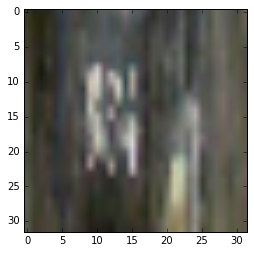

showing some labels and images for valid
data shape:  (1670, 1024)
labels shape:  [(1670, 10), (1670, 11), (1670, 11)]
[3, 0, 0]


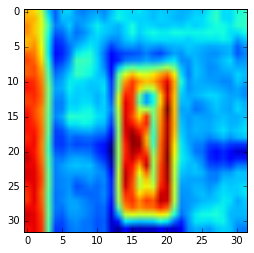

[3.0]


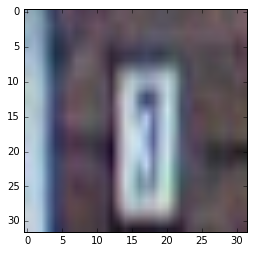

[1, 2, 4]


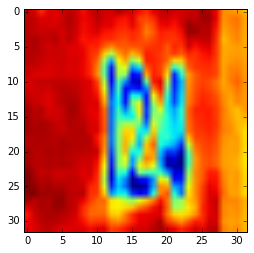

[1.0, 2.0, 4.0]


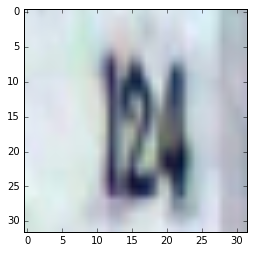

[5, 3, 0]


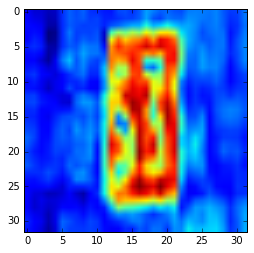

[5.0, 3.0]


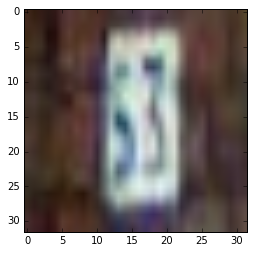

[1, 2, 9]


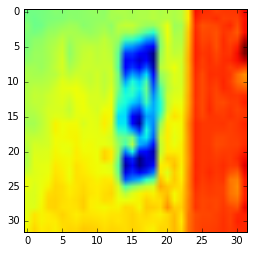

[1.0, 2.0, 9.0]


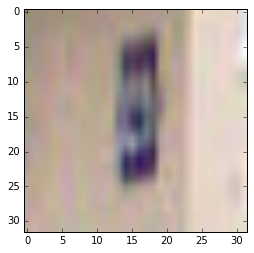

[1, 1, 7]


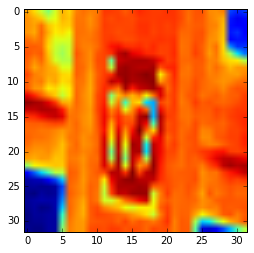

[1.0, 1.0, 7.0]


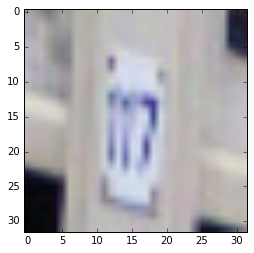

showing some labels and images for test
data shape:  (13068, 1024)
labels shape:  [(13068, 10), (13068, 11), (13068, 11)]
[5, 3, 0]


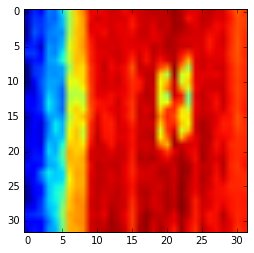

[5.0, 3.0]


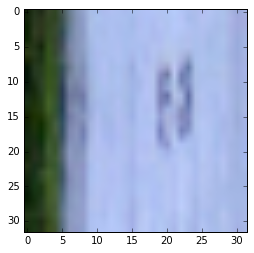

[1, 4, 4]


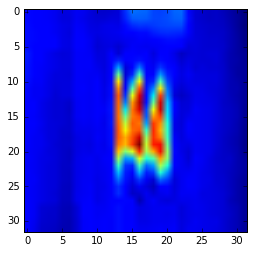

[1.0, 4.0, 4.0]


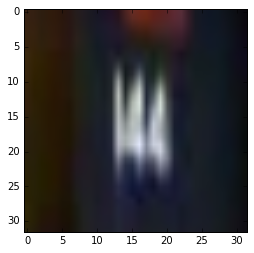

[3, 10, 0]


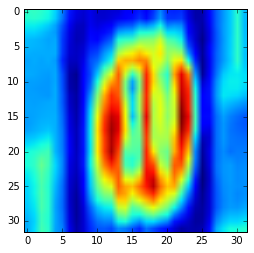

[3.0, 10.0]


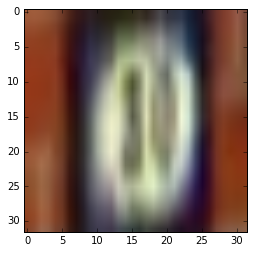

[6, 7, 0]


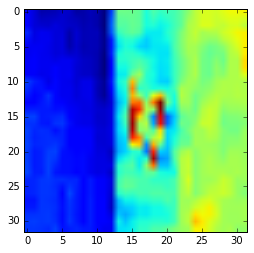

[6.0, 7.0]


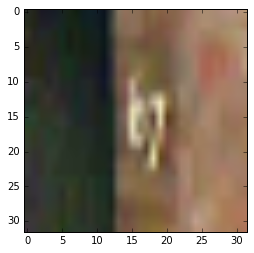

[1, 4, 0]


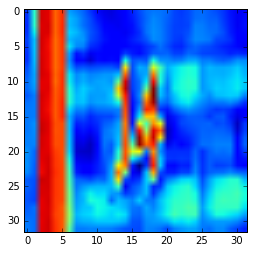

[1.0, 4.0]


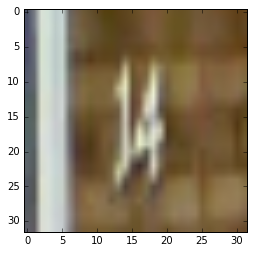

In [99]:
def display_image(image):
    plt.figure()
    plt.imshow(image)
    plt.show()
    
def display_images(data,labels,loaded_data,loaded_labels,name=None,num_images=5,single_digit=False):
    print ("showing some labels and images for %s"%name)  
    print ("data shape: ",data.shape)
    if single_digit:
        label_shape=labels.shape
    else:
        label_shape=[label.shape for label in labels]
    print("labels shape: ",label_shape)
    total_images=data.shape[0]
    for i in np.random.choice(total_images,num_images):
            if single_digit:
                print(from_one_hot(labels[i]))
            else:
                print([from_one_hot(label[i]) for label in labels])            
            display_image(data[i].reshape(image_size,image_size))
            if loaded_data!=None:
                print(loaded_labels[i])
                display_image(loaded_data[i])
            
display_images(train_data,train_labels,loaded_train_data,loaded_train_labels,"train")
display_images(valid_data,valid_labels,loaded_valid_data,loaded_valid_labels,"valid")
display_images(test_data,test_labels,loaded_test_data,loaded_test_labels,"test")

In [6]:
class IndexGenerator(object):
    """generates the next index of the data from wich we can take a subset of length batch_size"""
    def __init__(self, length, batch_size):
        self._step=0
        self._length=length
        self._batch_size=batch_size
    def _next(self):
        offset = (self._step * self._batch_size) % (self._length - self._batch_size)
        self._step=self._step+1
        return offset
        
train_batch_size=64
valid_batch_size=64
test_batch_size=64
train_index_generator=IndexGenerator(len(train_data),train_batch_size)
valid_index_generator=IndexGenerator(len(valid_data),valid_batch_size)
test_index_generator=IndexGenerator(len(test_data),test_batch_size)
#print("train indexes:",train_index_generator._next(),train_index_generator._next(),train_index_generator._next(),train_index_generator._next())
#for i in range(100):
#    print(valid_index_generator._next())

In [113]:
class BatchGenerator(object):
    """generates a batch of data balancing zeros(blanc labels) with other labels"""
    def __init__(self,labels,batch_size):
        self.step=0
        self.batch_size=batch_size
        self.length=labels.shape[0]
        self.with_zeros=(labels.shape[1]==num_labels)        
        indices=np.arange(labels.shape[0])
        self.indices=indices
        np.random.shuffle(indices)
        if self.with_zeros:
            zero_indices=indices[np.argmax(labels,1)==0]
            other_indices=indices[np.argmax(labels,1)!=0]
            self.zero_count=zero_indices.shape[0]
            self.other_count=other_indices.shape[0]
            assert self.zero_count+self.other_count==labels.shape[0], "different lengths found:%d + %d != %d"% (self.zero_count,
                                                                                                                self.other_count,labels.shape[0])
            self.zero_indices=zero_indices
            self.other_indices=other_indices
            self.zeroes_batch_size=batch_size/num_labels
            self.other_batch_size=batch_size-self.zeroes_batch_size
            
        
    def _next(self):
        if self.with_zeros:
            indices=[]
            zero_offset = (self.step * self.zeroes_batch_size) % (self.zero_count - self.zeroes_batch_size)
            indices.extend(self.zero_indices[zero_offset:zero_offset+self.zeroes_batch_size])
            other_offset = (self.step * self.other_batch_size) % (self.other_count - self.other_batch_size)
            indices.extend(self.other_indices[other_offset:other_offset+self.other_batch_size])
            assert len(indices)==self.batch_size, "foung bad indices size: %d!=%d"%(len(indices),self.batch_size)
        else:
            offset = (self.step * self.batch_size) % (self.length - self.batch_size)
            indices=self.indices[offset:offset+self.batch_size]
        self.step+=1        
        np.random.shuffle(indices)
        return indices
    
train_batch_generators=[BatchGenerator(labels,train_batch_size) for labels in train_labels]
        
        

showing some labels and images for some images from the generated batches by generator 0
data shape:  (64, 1024)
labels shape:  (64, 10)
1


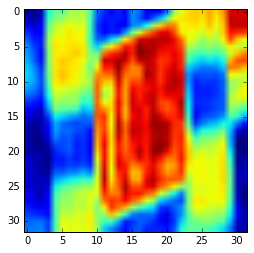

1


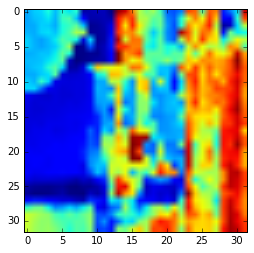

3


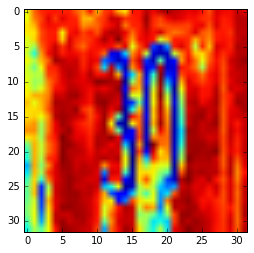

2


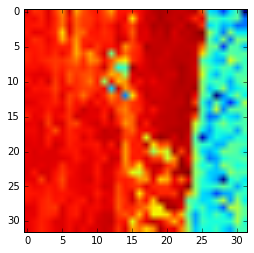

1


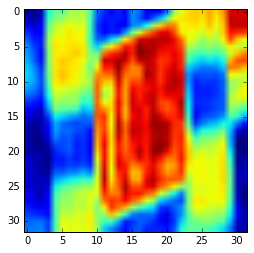

showing some labels and images for some images from the generated batches by generator 1
data shape:  (64, 1024)
labels shape:  (64, 11)
2


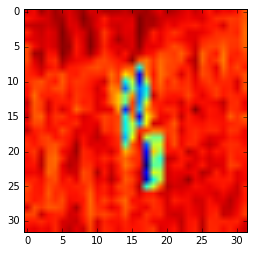

2


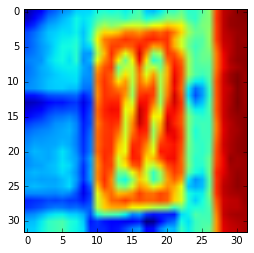

7


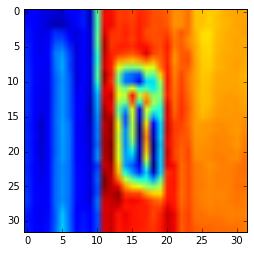

6


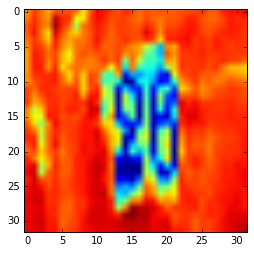

5


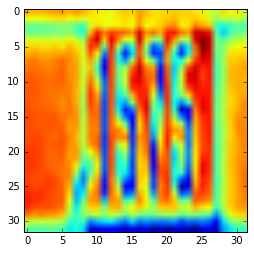

showing some labels and images for some images from the generated batches by generator 2
data shape:  (64, 1024)
labels shape:  (64, 11)
0


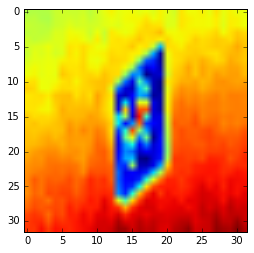

0


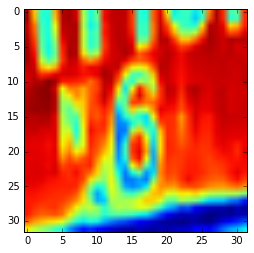

0


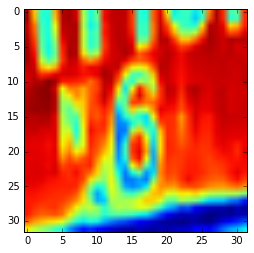

0


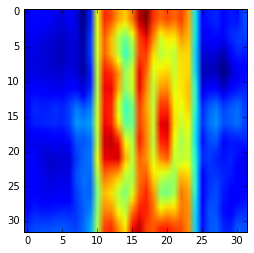

8


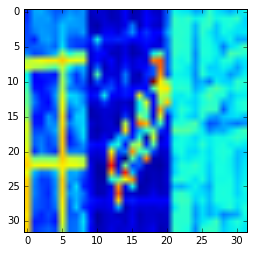

In [115]:
for index,generator in enumerate(train_batch_generators):  
    generator.step=31732
    indices=generator._next()
    data=train_data[indices,:]
    labels=train_labels[index][indices,:]
    display_images(data,labels,None,None,name="some images from the generated batches by generator %d"%(index),single_digit=True)
    
    

In [118]:
generator=train_batch_generators[1]
print(np.argmax(train_labels[1][generator._next(),:],1))


[ 3 10 10  6  8  1 10  3  2  8  6  2  6  0  0  2  8  0  6  4  9  2  6  1  6
  0  1 10  6  3  2  7  0  3  4  0 10  4  7  1  0  8  2  7  0  2  5  4  8 10
  8 10  9  1  5  2  5  5  8  3 10  3  0  1]


## Build the graph

In [30]:
squared_image_size=image_size*image_size
rnn_num_hidden=squared_image_size
graph = tf.Graph()
with graph.as_default():   
   
    #data
    tf_data = tf.placeholder(tf.float32, [None, squared_image_size])
    tf_labels = tf.placeholder(tf.float32, [None, max_labels, num_labels])
    
    #rnn computation (see https://danijar.com/variable-sequence-lengths-in-tensorflow/)
    
    # repeat the images for dynamic rnn
    repeated_data=tf.tile(tf_data,[1,max_labels])
    rnn_data=tf.reshape(repeated_data,[-1,max_labels,squared_image_size])
    
    # Sequence length
    rnn_length=tf.fill(tf.slice(tf.shape(rnn_data),[0],[1]),max_labels)
    
    #dynamic rnn
    output, _ = tf.nn.dynamic_rnn(
        tf.nn.rnn_cell.GRUCell(rnn_num_hidden),
        rnn_data,
        dtype=tf.float32,
        sequence_length=rnn_length)
    
            
    # Classifier weights and biases.
    weights = tf.Variable(tf.truncated_normal([rnn_num_hidden, num_labels], stddev=0.1))
    biases = tf.Variable(tf.ones([num_labels]))
    
    #prediction
    output = tf.reshape(output, [-1, rnn_num_hidden])
    prediction = tf.nn.softmax(tf.matmul(output, weights) + biases)
    prediction = tf.reshape(prediction, [-1, max_labels, num_labels])
    
    #mask to avoid taking blank labels into account in loss and precision
    mask = tf.sign(tf.arg_max(tf_labels,2))
    mask=tf.cast(mask,tf.float32)    
    
    #length vector
    length = tf.reduce_sum(mask, reduction_indices=1)
    count=tf.reduce_sum(length)#number of non null labels
    
    
    
    # loss
    cross_entropy = tf_labels * tf.log(prediction)
    cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)    
    cross_entropy *= mask
    cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
    loss=tf.reduce_sum(cross_entropy)/count
    loss=loss+3*tf.contrib.losses.cosine_distance(prediction,tf_labels,2)
    
    # accuracy
    hundred=tf.constant(100.0,tf.float32)
    correct = tf.equal(
        tf.argmax(tf_labels, 2), tf.argmax(prediction, 2))
    correct = tf.cast(correct, tf.float32)
    masked_correct = correct* mask
    masked_sum = tf.reduce_sum(masked_correct, reduction_indices=1)
    accuracy = hundred*tf.reduce_sum(masked_sum)/count
    
    # optimizer
    learning_rate = 0.0003
    error=(hundred-accuracy)/hundred
    loss=tf.log(error)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Initialized
Loss at step 0: -0.083699
Training accuracy: 8.0%
Validation accuracy: 6.7%
Loss at step 10: -0.126563
Training accuracy: 11.9%
Validation accuracy: 8.0%
Loss at step 20: -0.051293
Training accuracy: 5.0%
Validation accuracy: 7.2%
Loss at step 30: -0.069959
Training accuracy: 6.8%
Validation accuracy: 10.9%
Loss at step 40: -0.150823
Training accuracy: 14.0%
Validation accuracy: 9.5%
Loss at step 50: -0.060219
Training accuracy: 5.8%
Validation accuracy: 9.2%
Loss at step 60: -0.077558
Training accuracy: 7.5%
Validation accuracy: 8.9%
Loss at step 70: -0.095310
Training accuracy: 9.1%
Validation accuracy: 6.7%
Loss at step 80: -0.089128
Training accuracy: 8.5%
Validation accuracy: 9.0%
Loss at step 90: -0.068520
Training accuracy: 6.6%
Validation accuracy: 5.6%
Loss at step 100: -0.084341
Training accuracy: 8.1%
Validation accuracy: 5.5%
Loss at step 110: -0.071973
Training accuracy: 6.9%
Validation accuracy: 5.5%
Loss at step 120: -0.082444
Training accuracy: 7.9%
Validati

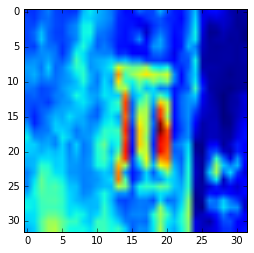

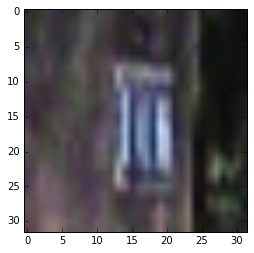

[[8 8 8 8 8 8]]


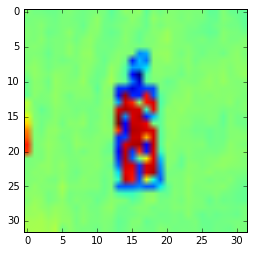

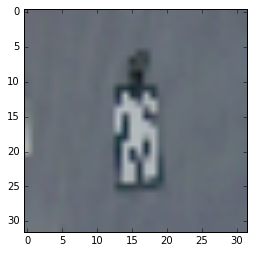

[[8 8 8 8 8 8]]


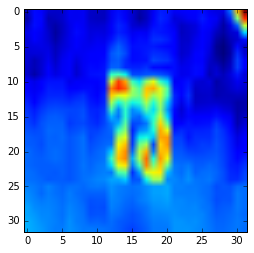

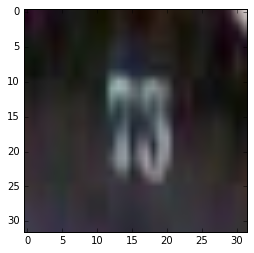

[[8 8 8 8 8 8]]


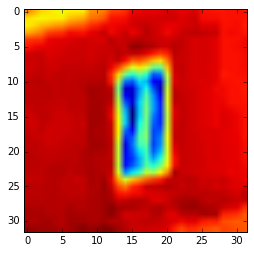

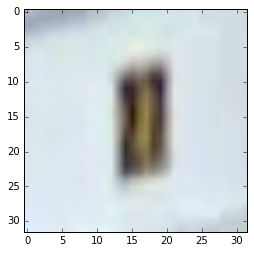

[[5 5 5 5 5 5]]


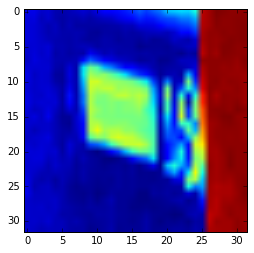

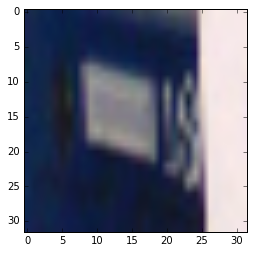

In [31]:
num_steps = 1000001

def feed_dict(offset,size,data,labels=None):
    dic={}
    dic[tf_data]=data[offset:offset+size]
    if labels!=None:
        dic[tf_labels]=labels[offset:offset+size]
    return dic

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    try:
        for step in range(num_steps):
            train_offset=train_index_generator._next()
            train_feed_dict=feed_dict(train_offset,train_batch_size,train_data,train_labels)
            session.run([optimizer],feed_dict=train_feed_dict)
            if (step % 10 == 0):
                train_loss,train_accuracy=session.run([loss,accuracy],feed_dict=train_feed_dict)
                print('Loss at step %d: %f' % (step, train_loss))
                print('Training accuracy: %.1f%%' % train_accuracy)
                
                valid_offset=valid_index_generator._next()
                valid_feed_dict=feed_dict(valid_offset,valid_batch_size,valid_data,valid_labels)
                print('Validation accuracy: %.1f%%' % accuracy.eval(feed_dict=valid_feed_dict))
    except KeyboardInterrupt:        
        test_offset = test_index_generator._next()
        test_feed_dict = feed_dict(test_offset,test_batch_size,test_data,test_labels)
        print('Test accuracy: %.1f%%' % accuracy.eval(feed_dict=test_feed_dict))
        test_prediction=prediction.eval(feed_dict=test_feed_dict)
        display_images(test_data[test_offset:test_offset+test_batch_size],test_prediction,
                      loaded_test_data[test_offset:test_offset+test_batch_size],"displaying predicted labels")

In [38]:
processed=[list() for i in range(3)]
processed[1].append(2)
print(processed)
i=4
processed[i] if i<len(processed) else 0

[[], [2], []]


0

In [10]:
help(tf.contrib.losses.sigmoid_cross_entropy)

Help on function sigmoid_cross_entropy in module tensorflow.contrib.losses.python.losses.loss_ops:

sigmoid_cross_entropy(logits, multi_class_labels, weight=1.0, label_smoothing=0, scope=None)
    Creates a cross-entropy loss using tf.nn.sigmoid_cross_entropy_with_logits.
    
    Args:
      logits: [batch_size, num_classes] logits outputs of the network .
      multi_class_labels: [batch_size, num_classes] target labels in (0, 1).
      weight: Coefficients for the loss. The tensor must be a scalar, a tensor of
        shape [batch_size] or shape [batch_size, num_classes].
      label_smoothing: If greater than 0 then smooth the labels.
      scope: The scope for the operations performed in computing the loss.
    
    Returns:
      A scalar `Tensor` representing the loss value.



In [26]:
with tf.Session() as session:

    # testin cosine distance
    a = tf.constant([[[1.0, 0.0],[0.0,1.0]],
                    [[0.0, 1.0],[0.0,1.0]]])
    b = tf.constant([[[0.0, 1.0],[0.0,1.0]],
                    [[0.0, 1.0],[0.0,1.0]]])
    c = tf.constant([[[0.95,0.05],[0.05,0.95]],
                    [[0.05,0.95],[0.05,0.95]]])

    dist =tf.contrib.losses.cosine_distance
    print("dim:",a.get_shape())
    print("aa: ",dist(a,a,2).eval())
    print("ab: ",dist(a,b,2).eval())
    print("ac: ",dist(a,c,2).eval())
    print("bc: ",dist(b,c,2).eval())
    print("cb: ",dist(c,b,2).eval())
    
    print("loga:",tf.log(a).eval())

    def reshape_and_normalize(vector):
        reshaped=tf.reshape(vector,[1,])
        length=vector.get_shape()[1]
        return reshaped/tf.cast(length,tf.float32)

    def reshaped_dist(pred,tar):
        return dist(reshape_and_normalize(pred),reshape_and_normalize(tar),1)


dim: (2, 2, 2)
aa:  0.0
ab:  0.25
ac:  0.05
bc:  0.275
cb:  0.275
loga: [[[  0. -inf]
  [-inf   0.]]

 [[-inf   0.]
  [-inf   0.]]]


In [78]:
help(np.argmax)

Help on function argmax in module numpy.core.fromnumeric:

argmax(a, axis=None)
    Indices of the maximum values along an axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        By default, the index is into the flattened array, otherwise
        along the specified axis.
    
    Returns
    -------
    index_array : ndarray of ints
        Array of indices into the array. It has the same shape as `a.shape`
        with the dimension along `axis` removed.
    
    See Also
    --------
    ndarray.argmax, argmin
    amax : The maximum value along a given axis.
    unravel_index : Convert a flat index into an index tuple.
    
    Notes
    -----
    In case of multiple occurrences of the maximum values, the indices
    corresponding to the first occurrence are returned.
    
    Examples
    --------
    >>> a = np.arange(6).reshape(2,3)
    >>> a
    array([[0, 1, 2],
           [3, 4, 5]])
    >>> np.argmax(a)
    5
    >>> 